<a href="https://colab.research.google.com/github/Bypasser8/Earthbarrier/blob/main/cloud%20scripts/cuda_kernel_031924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=d1a7ef0cf64806cbf3f982cfbec05c5c1668b355a0a39067bb9c03619de51a5b
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


In [2]:
cuda_kernel = """__global__ void conwaysGameOfLife(int *currentWorld, int *nextWorld, int width, int height, int num_parameters, float *printOut) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // Count live neighbors
    int radius1 = 7;
    int radius2 = 2;

    float parameters_neighborhood[2] = {0, 0};
    int count[2] = {0, 0};

    for (int z = 0; z < num_parameters; z++) {
        for (int dy = -radius1; dy <= radius1; dy++) {
            for (int dx = -radius1; dx <= radius1; dx++) {
                if (dx == 0 && dy == 0) continue; // Skip the cell itself
                int distanceSquared = dx*dx + dy*dy;
                int nx = x + dx;
                int ny = y + dy;

                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    if (distanceSquared <= radius1*radius1) {
                        parameters_neighborhood[0] += currentWorld[ny * width + nx];
                        count[0]++;

                        if (distanceSquared <= radius2*radius2) {
                            parameters_neighborhood[1] += currentWorld[ny * width + nx];
                            count[1]++;
                            }
                        }
                    }
                }
            }
        }
    }

    if (count[0] > 0) {
        parameters_neighborhood[0] /= count[0]; // Alive
    }
    if (count[1] > 0) {
        parameters_neighborhood[1] /= count[1]; // Trophic value
    }

    for (int z = 0; z < num_parameters; z++) {
        // Apply the rules
        float outputValue = currentWorld[(y * width + x) * num_parameters + z]; // REFERENCE_VALUE is the current state
        if (parameters_neighborhood[0] == 1.0f) {
            if (parameters_neighborhood[1] >= outputValue) outputValue -= 1.0f;
        }
        if (parameters_neighborhood[0] == 0.0f) {
            parameters_neighborhood[1] = 0.0f;
        }

        if (outputValue <= 1) outputValue = 0;
        nextWorld[(y * width + x) * num_parameters + z] = outputValue;
    }
}
"""

In [8]:
cuda_kernel = """__global__ void conwaysGameOfLife(int *currentWorld, int *nextWorld, int width, int height, int num_parameters, float *printOut) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // Count live neighbors
    int radius1 = 2;

    float parameters_neighborhood[2] = {0, 0};
    int count[2] = {0, 0};

    for (int z = 0; z < num_parameters; z++) {
        float cellState = currentWorld[(y * width + x) * num_parameters]; // Assuming the first parameter is the state
        float trophicValue = currentWorld[(y * width + x) * num_parameters + 1]; // Assuming the second parameter is the trophic value

        float maxTrophicNeighbour = 0.0f;
        float minTrophicNeighbour = 0.0f; // You need to include <float.h>

        // Evaluate the neighborhood
        for (int dy = -radius1; dy <= radius1; dy++) {
            for (int dx = -radius1; dx <= radius1; dx++) {
                if (dx == 0 && dy == 0) continue; // Skip the cell itself
                int nx = x + dx;
                int ny = y + dy;

                if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                    float neighbourTrophicValue = currentWorld[(ny * width + nx) * num_parameters + 1];
                    maxTrophicNeighbour = fmaxf(maxTrophicNeighbour, neighbourTrophicValue);
                    minTrophicNeighbour = fminf(minTrophicNeighbour, neighbourTrophicValue);
                }
            }
        }

        float outputValue = cellState;

        // Trophic interactions
        if (cellState > 0) { // If the cell is alive
            if (trophicValue < maxTrophicNeighbour) {
                // Cell might be consumed or weakened
                outputValue = 0; // or some other logic
            } else if (trophicValue > minTrophicNeighbour) {
                // Cell might grow or consume other cells
                outputValue = 1; // or some other logic
            }
        }

        nextWorld[(y * width + x) * num_parameters + z] = outputValue;
    }
}
"""

In [12]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

# Compile the kernel code
mod = SourceModule(cuda_kernel)

# Get the kernel function from the compiled module
conwaysGameOfLife = mod.get_function("conwaysGameOfLife")

# Prepare data for Conway's Game of Life
height, width, parameters = 100, 100, 2  # Example dimensions, adjust as needed
currentWorld = np.random.choice([0, 1], size=(height, width)).astype(np.int32)  # Random initial state
nextWorld = np.zeros_like(currentWorld).astype(np.int32)  # Placeholder for the next state
printOut = np.zeros_like(currentWorld, dtype='float32')  # Placeholder for the printout
print('Initialization:')
print(currentWorld)

# Allocate GPU memory and copy the initial world state
printOut_cuda = cuda.mem_alloc(printOut.nbytes)
currentWorld_cuda = cuda.mem_alloc(currentWorld.nbytes)
nextWorld_cuda = cuda.mem_alloc(nextWorld.nbytes)
cuda.memcpy_htod(currentWorld_cuda, currentWorld)

# Define the block and grid sizes
block_dim = (16, 16, 1)
grid_dim = ((width + block_dim[0] - 1) // block_dim[0],
            (height + block_dim[1] - 1) // block_dim[1])

# Execute the kernel
conwaysGameOfLife(currentWorld_cuda, nextWorld_cuda, np.int32(width), np.int32(height), printOut_cuda,
                  block=block_dim, grid=grid_dim)

# Copy the result back to the host
cuda.memcpy_dtoh(nextWorld, nextWorld_cuda)
cuda.memcpy_dtoh(printOut, printOut_cuda)

# Display or process the next world state as needed
# For example, print a small portion of the world
print("One cycle:")
print(nextWorld[:10, :10])
print("Printout:")
print(printOut[:10, :10])

def run_simulation(timesteps, currentWorld, currentWorld_cuda, nextWorld, nextWorld_cuda):
    frames = [currentWorld.copy()]

    for _ in range(timesteps):
        conwaysGameOfLife(currentWorld_cuda, nextWorld_cuda, np.int32(width), np.int32(height),
                          block=block_dim, grid=grid_dim)

        currentWorld_cuda, nextWorld_cuda = nextWorld_cuda, currentWorld_cuda
        cuda.memcpy_dtoh(currentWorld, currentWorld_cuda)
        frames.append(currentWorld.copy())

    return frames

Initialization:
[[1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 1 1 ... 1 0 0]
 [0 0 0 ... 0 0 1]]
One cycle:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Printout:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [13]:
frames = run_simulation(50, currentWorld, currentWorld_cuda, nextWorld, nextWorld_cuda)

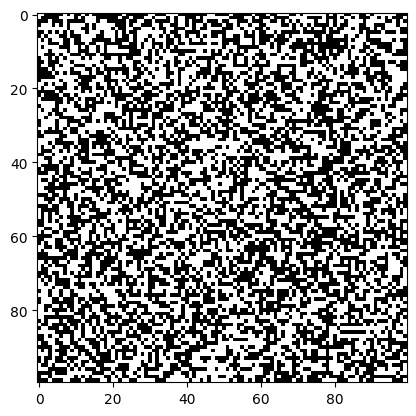

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming `frames` is your list of numpy arrays, each representing a frame
# frames = [...]  # Your list of frames here

fig, ax = plt.subplots()

# Display the first frame to set up the plot.
im = ax.imshow(frames[0], cmap='gray', interpolation='none')

def init():
    # Initialization function: plot the background of each frame
    im.set_data(frames[0])
    return (im,)

def update(frame_number):
    # Update function: this is called for each frame
    im.set_data(frames[frame_number])
    return (im,)

# Create the animation object
# Here, len(frames) is the number of frames you want to animate
ani = FuncAnimation(fig, update, frames=range(len(frames)), init_func=init, blit=True)

# To display the animation in the notebook
HTML(ani.to_jshtml())
